In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
import torch.autograd as autograd
from typing import List
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing


import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import scanpy as sc
import time
import os

import scipy

from torch.cuda.amp import GradScaler, autocast

torch.cuda.set_device(3)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
path= "../"
# check available files
# !ls ../real_data

# torch.autograd.set_detect_anomaly(True)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
adata = sc.read_h5ad("data/pbmc.h5ad")

# storing the layers count
adata.layers["counts"] = adata.X

In [3]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
adata.layers["X_raw"] = adata.X.copy()

In [5]:
# flavor: seurat_v3, cell_ranger & log = false
def sub_data_preprocess(adata: sc.AnnData, n_top_genes: int = 5000, batch_key: str = None, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3) -> sc.AnnData:
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    if flavor == 'seurat_v3':
# #         count data is expected when flavor=='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, flavor=flavor, batch_key = batch_key)
        sc.pp.highly_variable_genes(
            adata, flavor=flavor, batch_key = batch_key, n_top_genes=n_top_genes)

#     if flavor != 'seurat_v3':.
#         # log-format data is expected when flavor!='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, n_top_genes=n_top_genes, flavor=flavor)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    return adata


def data_preprocess(adata: sc.AnnData, key: str = 'batch', n_top_genes: int = 10000, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3, n_batch: int = 2) -> sc.AnnData:
    print('Establishing Adata for Next Step...')
    hv_adata = sub_data_preprocess(adata, n_top_genes=n_top_genes, batch_key = key, flavor=flavor, min_genes=min_genes, min_cells=min_cells)
    if len(adata.var.index) > n_top_genes:
        hv_adata = hv_adata[:, hv_adata.var['highly_variable']]
        
#     hv_adata.X = np.expm1(hv_adata.X)
    print('PreProcess Done.')
    return hv_adata

In [6]:
batch_str = "batch"

adata = data_preprocess(adata, batch_str)
adata  # Output the basic information of the preprocessed data.

Establishing Adata for Next Step...
PreProcess Done.


View of AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'
    var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'log1p'
    layers: 'counts', 'X_raw'

In [7]:
adata.layers["log_norm"] = adata.X

In [8]:
label_str = "batch"

# split per batch into new objects.
batches = list(set(adata.obs[label_str]))
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs[label_str] == batch,]

length_data = []

for batch in batches:
    length = len(alldata[batch])
    
    length_data.append(length)
    
# getting the batch with the most number of cell to be the anchoring/reference batch
anchor_index = np.argmax(length_data)

print(batches[anchor_index])

0


In [9]:
# # apply the pre processing onto the anndata
# # first create layer for the anndata
# adata.layers["X_raw"] = adata.X.copy()
# adata.layers["X_scaled"] = adata.X.copy()

# # split per batch into new objects.
# batches = list(set(adata.obs['batch']))
# # alldata_2 = {}

# # apply scaling to each batch in the pre process raw data
# for batch in batches:
# #     alldata[batch] = adata_int[adata_int.obs['Batch'] == batch,]

#     batch_index = adata.obs['batch'] == batch
#     temp_X = adata[batch_index].X
    
#     # log normalise data the same seurat
# #     sc.pp.normalize_per_cell(temp_adata, counts_per_cell_after = 1e4)
# #     sc.pp.log1p(temp_adata)
# #     temp_adata.layers["X_norm"] = temp_adata.X
    
#     # scaling of the data for PCA and UMAP embedding
#     temp_X_scaled = sc.pp.scale(temp_X, copy = True)
#     adata[batch_index].layers["X_scaled"] = temp_X_scaled

# # use this pancreatic data since it has been normalised already based on the author
# # adata.X = adata.layers["X_raw"].copy() # change to norm for count dataset

# # this is use for UMAP generation only for the raw dataset
# # adata.X = adata.layers["X_scaled"]

In [10]:
# # apply the pre processing onto the anndata
# # first create layer for the anndata

adata.layers["X_raw"] = adata.layers["log_norm"]

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scanorama

In [12]:
# var_genes_all = adata.var.highly_variable

# print("Highly variable genes: %d"%sum(var_genes_all))

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'batch')

print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata.var.highly_variable_nbatches > 0

Highly variable genes intersection: 358
Number of batches where gene is variable:
0    8813
1     829
2     358
Name: highly_variable_nbatches, dtype: int64


In [14]:
var_select = adata.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

0

In [15]:
# split per batch into new objects.
batches = adata.obs['batch'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['batch'] == batch,]

alldata

{'0': View of AnnData object with n_obs × n_vars = 8098 × 10000
     obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'
     var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     layers: 'counts', 'X_raw', 'log_norm',
 '1': View of AnnData object with n_obs × n_vars = 7378 × 10000
     obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'
     var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     layers: 'counts', 'X_raw', 'log_norm'}

In [16]:
adata.to_df()

,5,7,14,19,21,29,31,32,33,34,...,33656,33658,33661,33663,33675,33676,33683,33688,33689,33690
data_3p-AAACCTGAGCATCATC-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.644247,0.0,...,0.000000,3.934280,4.012817,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
data_3p-AAACCTGAGCTAGTGG-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.167015,0.0,...,0.000000,3.464906,2.928476,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
data_3p-AAACCTGCACATTAGC-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,3.114439,2.730933,1.523183,0.0,0.0,0.0,0.0,0.0,0.0
data_3p-AAACCTGCACTGTTAG-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,3.918071,3.731192,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
data_3p-AAACCTGCATAGTAAG-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,3.922954,3.549151,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
data_5p-TTTGTCATCCACGTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.927198,0.0,...,2.458898,3.997459,3.543946,0.927198,0.0,0.0,0.0,0.0,0.0,0.0
data_5p-TTTGTCATCGCGTAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,3.013757,3.980780,3.749358,1.876790,0.0,0.0,0.0,0.0,0.0,0.0
data_5p-TTTGTCATCTTAACCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,2.814095,3.554467,3.300645,2.814095,0.0,0.0,0.0,0.0,0.0,0.0
data_5p-TTTGTCATCTTACCGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,2.170512,3.189995,2.977092,0.937094,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#convert to list of AnnData objects
adatas = list(alldata.values())

# set the return_dimred = False for the corrected gene expression
corrected = scanorama.correct_scanpy(adatas, dimred = 50, return_dimred = True)

Found 10000 genes among all datasets
[[0.         0.66905409]
 [0.         0.        ]]
Processing datasets (0, 1)


In [18]:
corrected

[AnnData object with n_obs × n_vars = 8098 × 10000
     obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'
     var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     obsm: 'X_scanorama',
 AnnData object with n_obs × n_vars = 7378 × 10000
     obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'
     var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     obsm: 'X_scanorama']

In [19]:
adata_int_corr = sc.concat(corrected)

In [20]:
# scanorama_int = [ad.X.toarray() for ad in corrected]

# all_s = np.concatenate(scanorama_int)

corrected_df = pd.DataFrame(adata_int_corr.X.toarray(), columns = adata_int_corr.to_df().columns)
# corrected_df = 

In [21]:
corrected_df[adata.to_df().columns]

,5,7,14,19,21,29,31,32,33,34,...,33656,33658,33661,33663,33675,33676,33683,33688,33689,33690
0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042714,0.000000,...,0.000000,0.102205,0.104245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032453,0.000000,...,0.000000,0.096355,0.081438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.094678,0.083019,0.046304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.087743,0.083558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.086817,0.078545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15471,-1.614991e-06,-2.059660e-05,-0.000016,0.000018,0.000918,-0.000048,0.000009,0.002144,0.024022,-0.000007,...,-0.000053,0.092685,0.081996,0.001189,0.000008,-0.000011,0.001246,-0.005157,-0.000018,-0.000057
15472,-3.803093e-07,-9.244124e-07,-0.000024,-0.000008,0.001056,-0.000027,-0.000014,0.000563,0.003360,-0.000022,...,0.002827,0.098702,0.095572,0.011681,0.000099,-0.000104,0.000413,-0.000901,-0.000234,-0.000153
15473,-2.782460e-07,9.902623e-06,-0.000012,-0.000026,0.001085,-0.000061,-0.000017,0.000381,0.004412,-0.000060,...,-0.002306,0.087847,0.087368,0.035409,0.000027,-0.000036,0.000582,-0.002905,-0.000026,-0.000052
15474,-3.000216e-07,-3.968448e-06,-0.000022,-0.000002,0.001435,-0.000027,-0.000080,0.001467,0.002407,-0.000014,...,-0.007380,0.072886,0.071894,-0.003117,0.000020,0.000002,0.000395,-0.002693,-0.000052,-0.000050


In [22]:
output_results = corrected_df[adata.to_df().columns].values.copy()

In [23]:
output_results.shape

(15476, 10000)

In [24]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=150, frameon=False, figsize=(3, 3), facecolor='white')


# observer batch effect
# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['batch', "celltype"],
#            palette=sc.pl.palettes.vega_20_scanpy)


In [25]:
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=["celltype"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [26]:
output_results.shape

(15476, 10000)

In [27]:
adata_int_corr

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'
    obsm: 'X_scanorama'

In [28]:
from sklearn.decomposition import PCA

adata_int_corr.obsm["X_latent"] = output_results.copy()

# output_results_norm = sc.pp.normalize_per_cell(output_results, counts_per_cell_after = 1e4, copy = True)
# output_results_log_norm = sc.pp.log1p(output_results_norm)
# output_results_scaled = sc.pp.scale(output_results_log_norm)
# output_results_scaled = sc.pp.scale(output_results, copy = True)

# adata.obsm["X_latent_norm"] = output_results_log_norm
# adata.obsm["X_latent_scaled"] = output_results_scaled.copy()

pca = PCA(n_components = 50, random_state = 8)

# pca.fit(sc.pp.scale(adata.obsm["X_latent"], copy = True))

# X_pca = pca.transform(sc.pp.scale(adata.obsm["X_latent"], copy = True))

pca.fit(adata_int_corr.obsm["X_latent"])

X_pca = pca.transform(adata_int_corr.obsm["X_latent"])

adata_int_corr.obsm["X_pca"] = X_pca

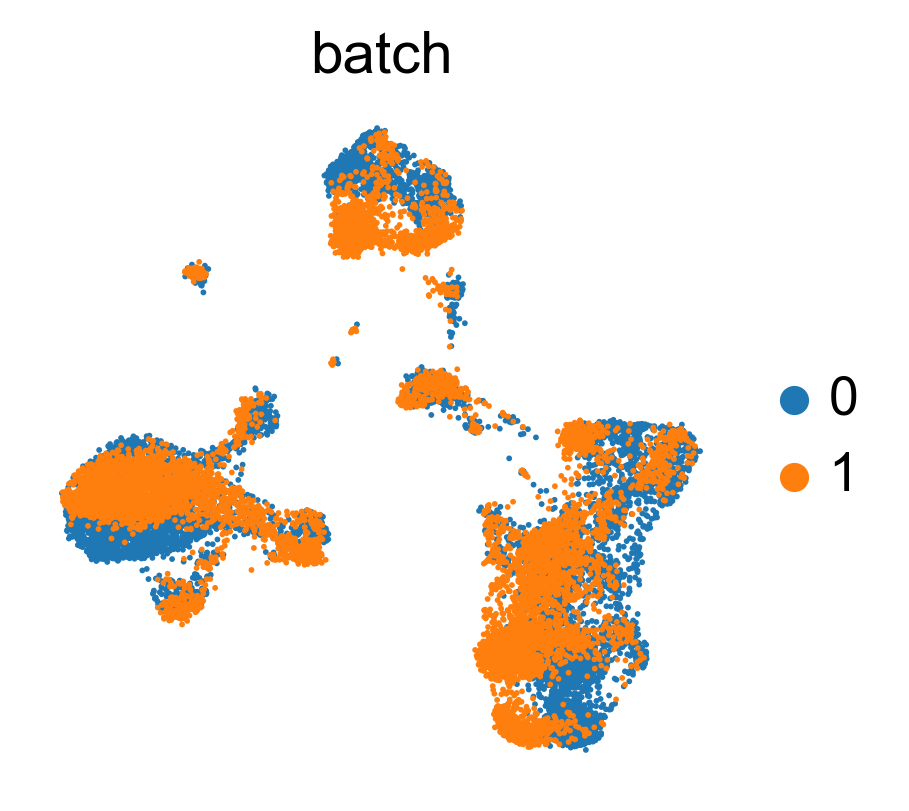

In [29]:
sc.pp.neighbors(adata_int_corr, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(adata_int_corr)
sc.pl.umap(adata_int_corr, color=['batch'],
           palette=sc.pl.palettes.vega_20_scanpy)


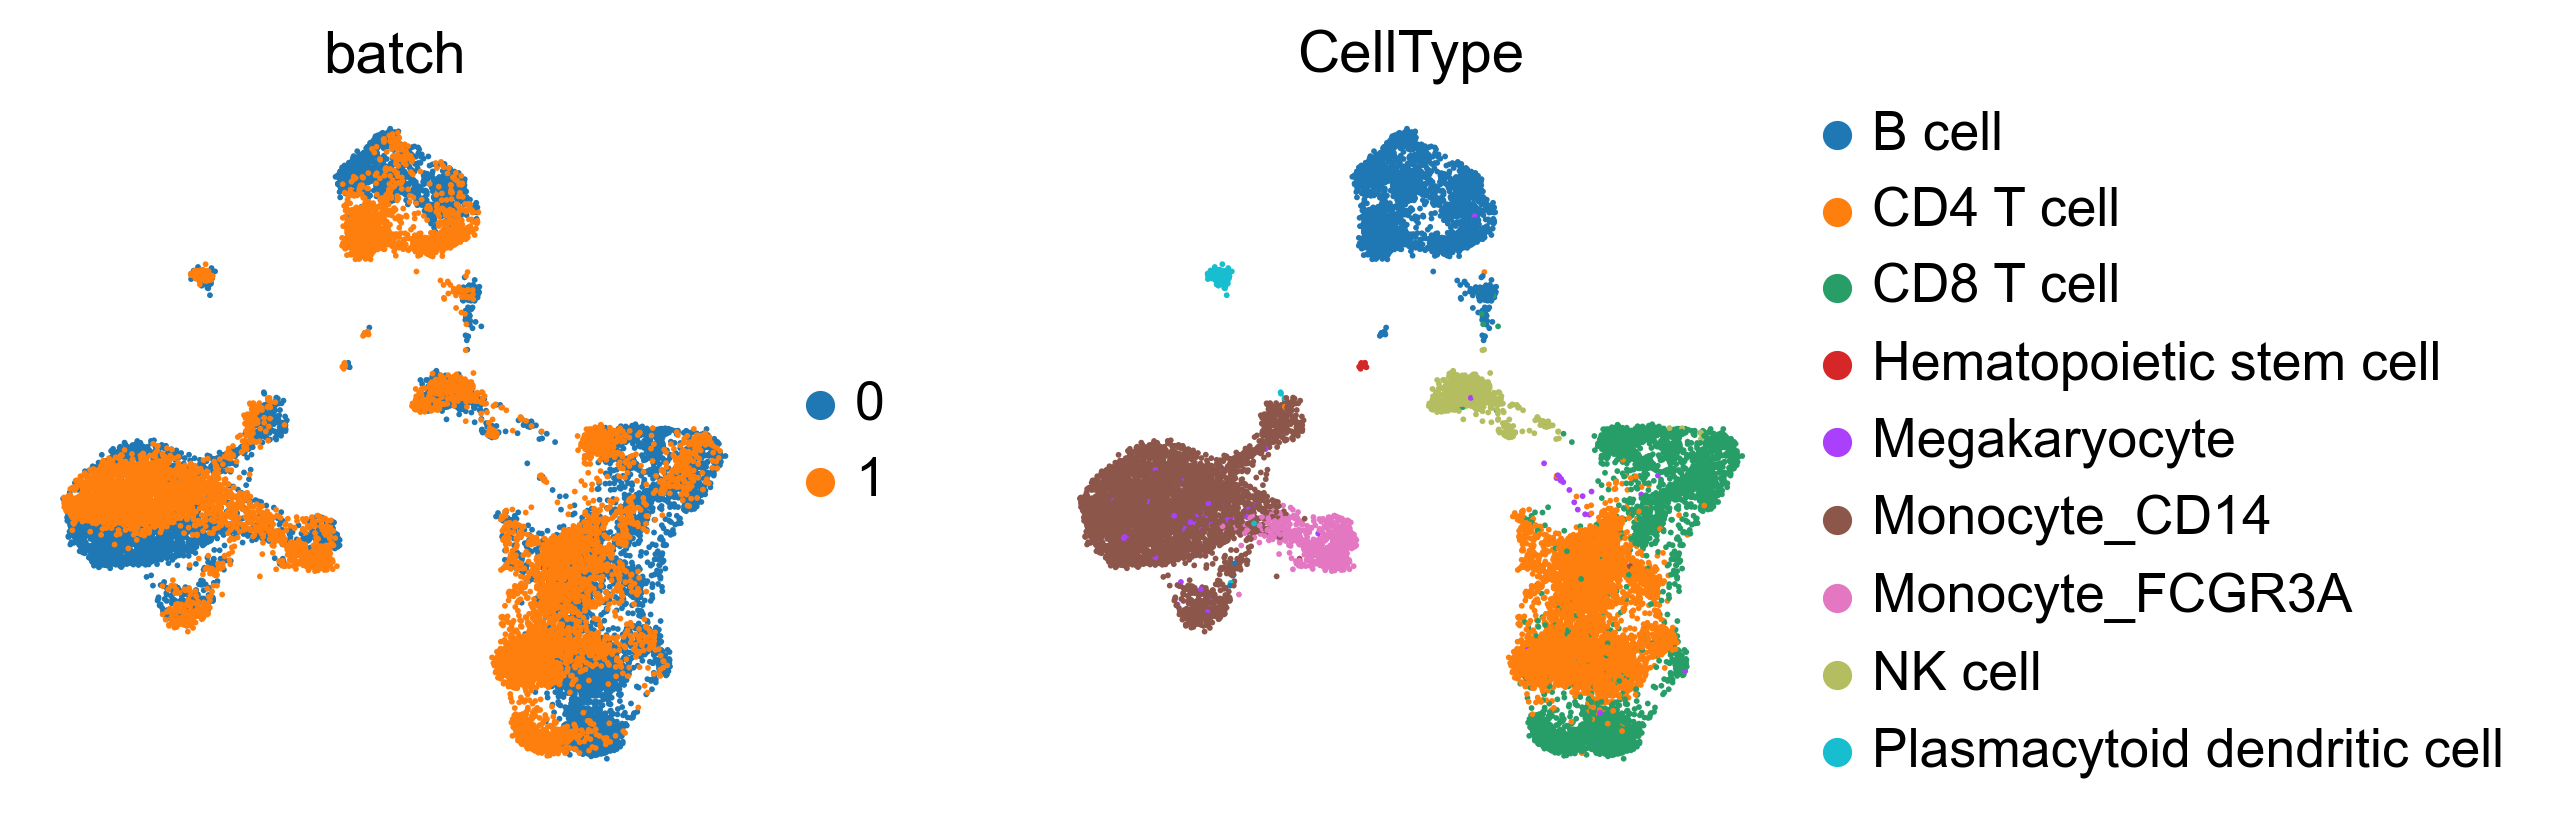

In [30]:
# adata.obsm["X_latent"] = output_results

# sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=30)
# sc.external.pp.bbknn(adata, batch_key='batch', use_rep='X_latent')
# sc.tl.umap(adata)
sc.pl.umap(adata_int_corr, color=["batch", "CellType"],
           palette=sc.pl.palettes.vega_20_scanpy)

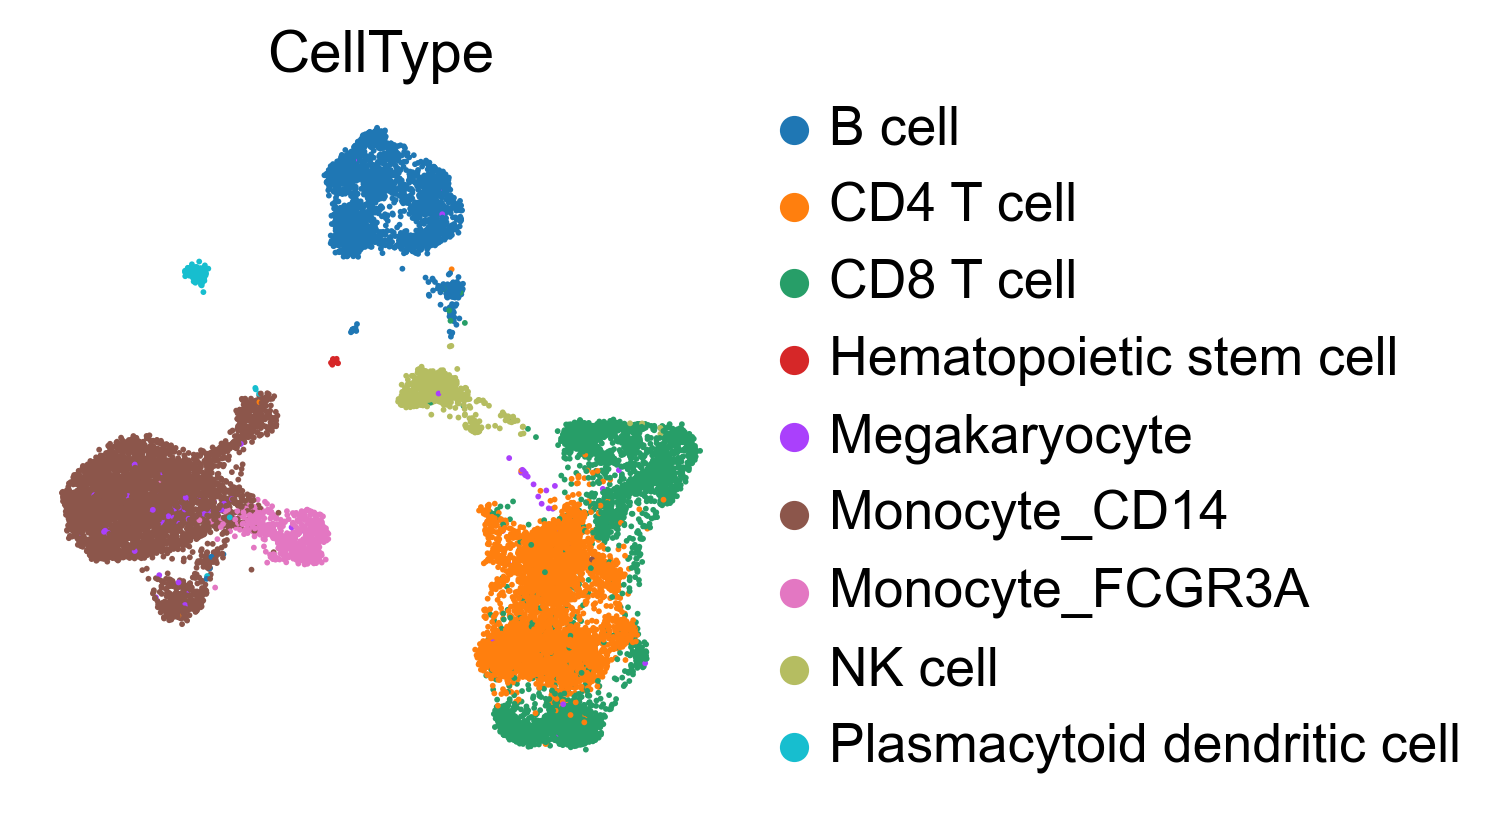

In [31]:
sc.pl.umap(adata_int_corr, color=["CellType"],
           palette=sc.pl.palettes.vega_20_scanpy)

In [32]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

resolutions = None

if resolutions is None:
    n = 20
    resolutions = [2 * x / n for x in range(1, n + 1)]

score_max = 0
res_max = resolutions[0]
clustering = None
score_all = []
use_rep = "X_pca"
cluster_key = "louvain"
label_key = "CellType"

sc.pp.neighbors(adata_int_corr, use_rep=use_rep)
    
for res in resolutions:
    sc.tl.louvain(adata_int_corr, resolution=res, key_added=cluster_key)
    score = ari(adata_int_corr, label_key, cluster_key)
    score_all.append(score)
    if score_max < score:
        score_max = score
        res_max = res
        clustering = adata_int_corr.obs[cluster_key]
        
score_max

0.7001772857063844

## Making the UMAP from the embeddings as well

In [33]:
adata_int_corr.obsm["X_scanorama"].shape

(15476, 50)

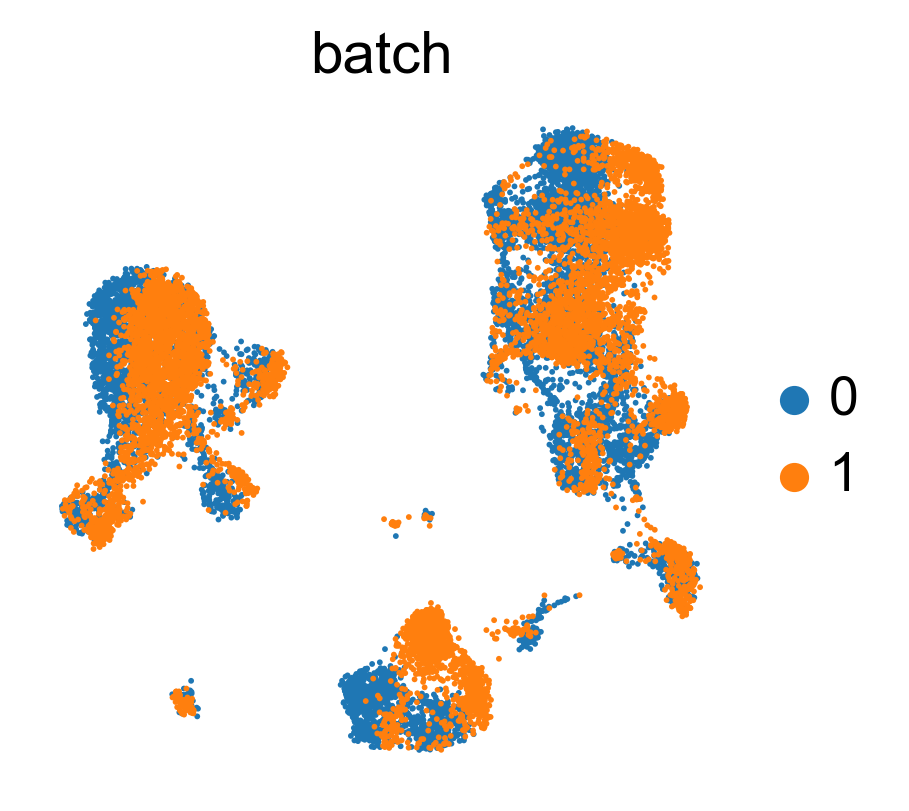

In [34]:
sc.pp.neighbors(adata_int_corr, use_rep='X_scanorama', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(adata_int_corr)
sc.pl.umap(adata_int_corr, color=['batch'],
           palette=sc.pl.palettes.vega_20_scanpy)

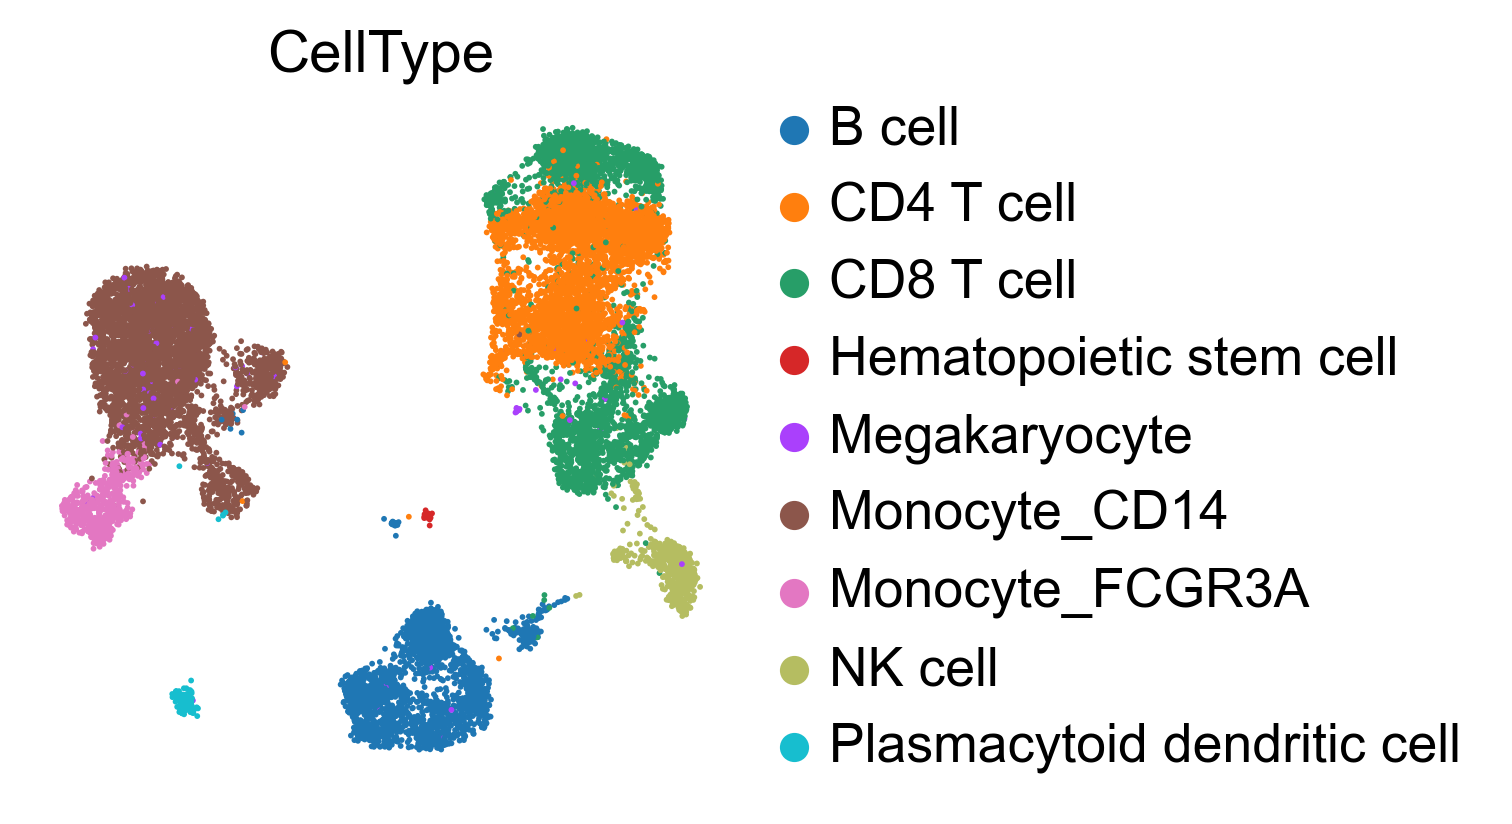

In [35]:
sc.pl.umap(adata_int_corr, color=["CellType"],
           palette=sc.pl.palettes.vega_20_scanpy)

In [36]:
# test_df = pd.DataFrame(output_results)
# sum(test_df.iloc[0,:])

In [37]:
adata_int_corr.write_h5ad("scanorama_pbmc.h5ad")

In [38]:
adata_int_corr

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'
    uns: 'neighbors', 'umap', 'batch_colors', 'CellType_colors', 'louvain'
    obsm: 'X_scanorama', 'X_latent', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [39]:
adata

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'
    var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'
    layers: 'counts', 'X_raw', 'log_norm'

In [40]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

resolutions = None

if resolutions is None:
    n = 20
    resolutions = [2 * x / n for x in range(1, n + 1)]

score_max = 0
res_max = resolutions[0]
clustering = None
score_all = []
use_rep = "X_scanorama"
cluster_key = "louvain"
label_key = "CellType"


sc.pp.neighbors(adata_int_corr, use_rep=use_rep)
    
for res in resolutions:
    sc.tl.louvain(adata_int_corr, resolution=res, key_added=cluster_key)
    score = ari(adata_int_corr, label_key, cluster_key)
    score_all.append(score)
    if score_max < score:
        score_max = score
        res_max = res
        clustering = adata_int_corr.obs[cluster_key]
        
score_max

0.6863157089039984